# A Machine Learning Approach to Estimate the Probability of an Individual to have Diabetes

This kernel will examine the prevalence of diabetes in adults based on common factors, that are understood to be correlated to the occurence of diabetes. It’s main focus lies within the analysis of 9 factors: Past pregnancies, blood glucose level, blood pressure, skin thickness, blood insulin level, body mass index (BMI), diabetes pedigree function, and age. The factors related to the occurrence will be analyzed to see what proportion each contributes to the occurrence of diabetes. We will see how the factors and attributes are interrelated by doing a pairwise comparison. We will use 3 main algorithms: "Support Vector Machine with a linear kernel", "Support vector machine with a radial kernel", "Linear regression", and the "Decision tree algorithm" to examine a matrix of 2000x10 data points, collected from hospitalized individuals in Frankfurt, Germany. By utilizing these algorithms we will examine the effectiveness of each in predicting the probability of a person to have diabetes based on the prevalence and results of the above mentioned diagnostic measurements.

In [1]:
# import the basic modules and functions for data analysis and visualisation in python
import pandas as pd #data processing
import numpy as np #linear algebra 
import matplotlib.pyplot as plt #data processing
import seaborn as sns #visualization and data processing
import itertools 
path = "datasets/diabetes.csv"
diabetes_data = pd.read_csv(path)


In [2]:
# first lets look at a few datapoints, to see what the data looks like.
diabetes_data.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [3]:
# gain more info about what data I am dealing with, 
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
Pregnancies                 2000 non-null int64
Glucose                     2000 non-null int64
BloodPressure               2000 non-null int64
SkinThickness               2000 non-null int64
Insulin                     2000 non-null int64
BMI                         2000 non-null float64
DiabetesPedigreeFunction    2000 non-null float64
Age                         2000 non-null int64
Outcome                     2000 non-null int64
dtypes: float64(2), int64(7)
memory usage: 140.7 KB


In [4]:
# basic statistical analysis of the data, to see if the data appears clean.
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.182500,69.145500,20.935000,80.254000,32.193000,0.470930,33.090500,0.342000
std,3.306063,32.068636,19.188315,16.103243,111.180534,8.149901,0.323553,11.786423,0.474498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.375000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.376000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.800000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000,1.000000


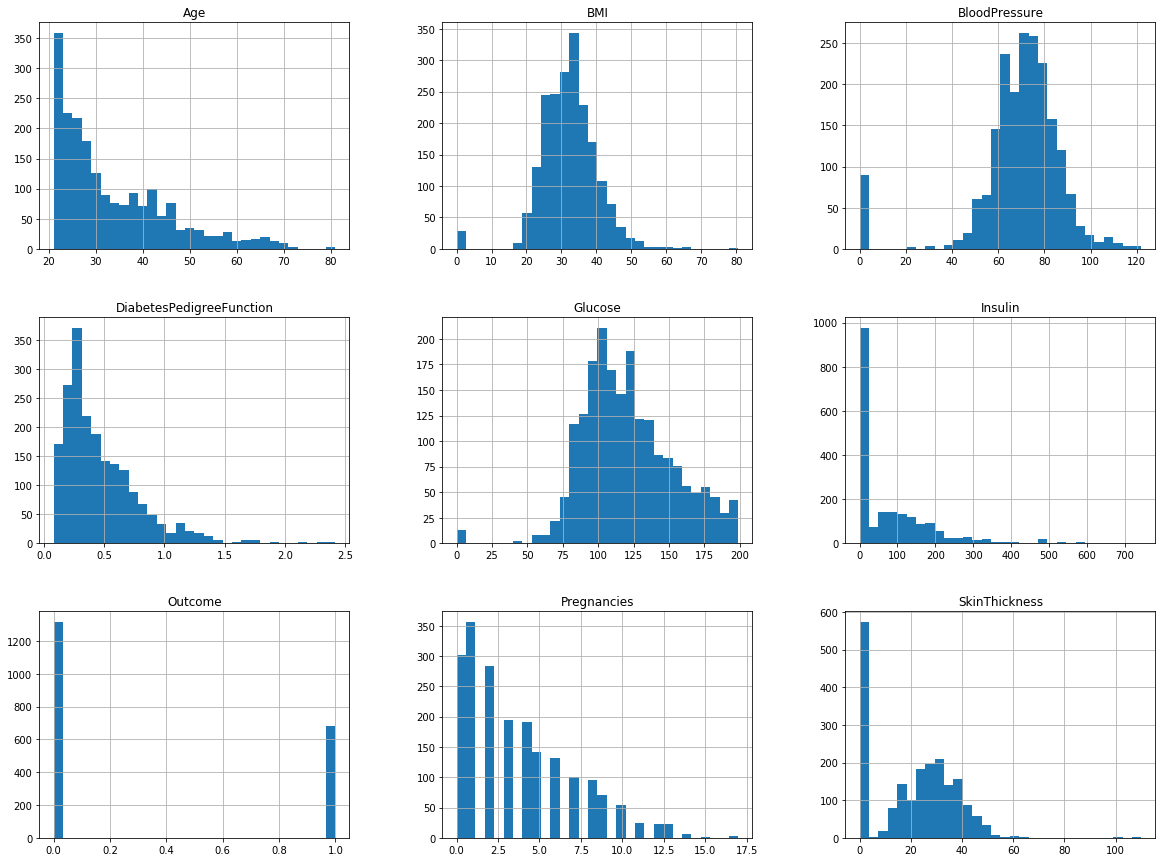

In [5]:
# lets exemplify the data visually using a histogram to see specific frequencies of occurence. 
#What features are skewed, are there any outliers? 
diabetes_data.hist(bins=30, figsize=(20,15))
plt.show()

The data consist of several medical predictors, which serve as our independent variables and one dependent (target) variable, namely the outcome. We can see, on the histogram, that at many occasions specific indicators of the patient have not been documented and occur as a high frequency on the 0 category bin. This is not changeble, as if we want to get rid of the unreported datapoints, it would delete the row, reducing our available data. So what do we do? Lets examine how much is missing.

In [6]:
print((diabetes_data[['Insulin','Glucose','BloodPressure','SkinThickness','BMI']] == 0).sum())

Insulin          956
Glucose           13
BloodPressure     90
SkinThickness    573
BMI               28
dtype: int64


This does not look too good, we would not have any value for the diagnostic measure of insulin for 956 patients. So what we will do is, substitute the missing values with the mean of the column to optimize our algorithms later on. First we will have to mark each 0 value of the attributes as either missing or NaN(Not a number).

In [7]:
# Mark the 0 Values as NaN
diabetes_data[['Insulin','Glucose','BloodPressure','SkinThickness','BMI']] = diabetes_data[['Insulin','Glucose','BloodPressure','SkinThickness','BMI']].replace(0, np.NaN)
print(diabetes_data.head(20)) #Result

    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0             2    138.0           62.0           35.0      NaN  33.6   
1             0     84.0           82.0           31.0    125.0  38.2   
2             0    145.0            NaN            NaN      NaN  44.2   
3             0    135.0           68.0           42.0    250.0  42.3   
4             1    139.0           62.0           41.0    480.0  40.7   
5             0    173.0           78.0           32.0    265.0  46.5   
6             4     99.0           72.0           17.0      NaN  25.6   
7             8    194.0           80.0            NaN      NaN  26.1   
8             2     83.0           65.0           28.0     66.0  36.8   
9             2     89.0           90.0           30.0      NaN  33.5   
10            4     99.0           68.0           38.0      NaN  32.8   
11            4    125.0           70.0           18.0    122.0  28.9   
12            3     80.0            NaN            

Now that the missing values are recorded as NaN, we can replace them with the mean of the columns. But why? Missing values can cause problems when utilizing machine leanrning algorithms. Highly optimized algorithms such as the support vector machine and the decision tree can misfunction and provide results that are biased. So by imputing the missing values with the mean, the algorithms will be able to classify better. 

In [8]:
# Fillna function serves this purpose, afterwards we print how many values are still 0.
diabetes_data.fillna(diabetes_data.mean(), inplace = True) 
print(diabetes_data.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


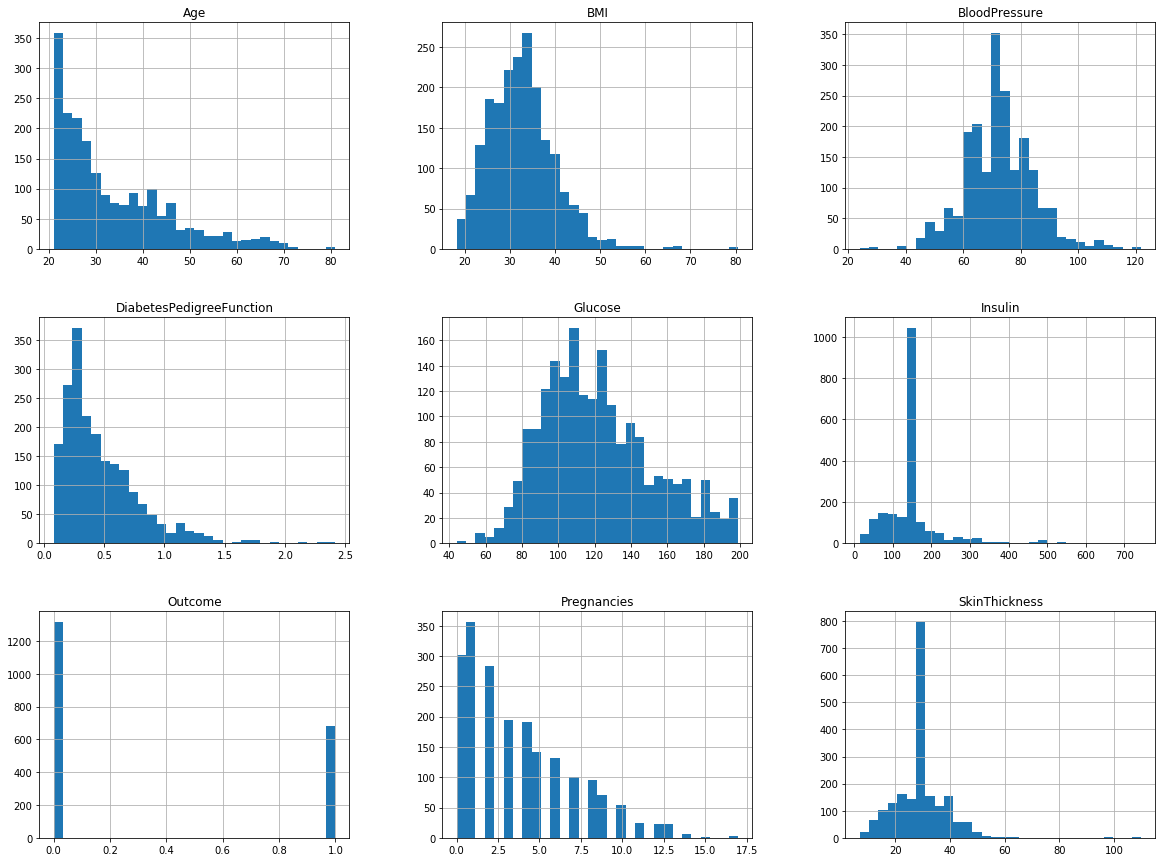

In [9]:
# Our data in Histograms with their missing values replaced by the mean. 
diabetes_data.hist(bins=30, figsize=(20,15))
plt.show()

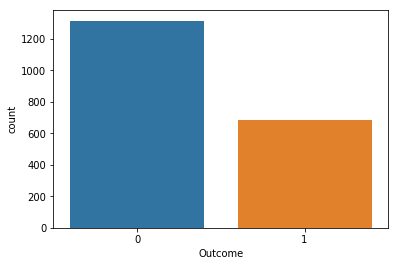

In [10]:
# A closer look at the outcome category. 
sns.countplot(x = 'Outcome', data=diabetes_data) 

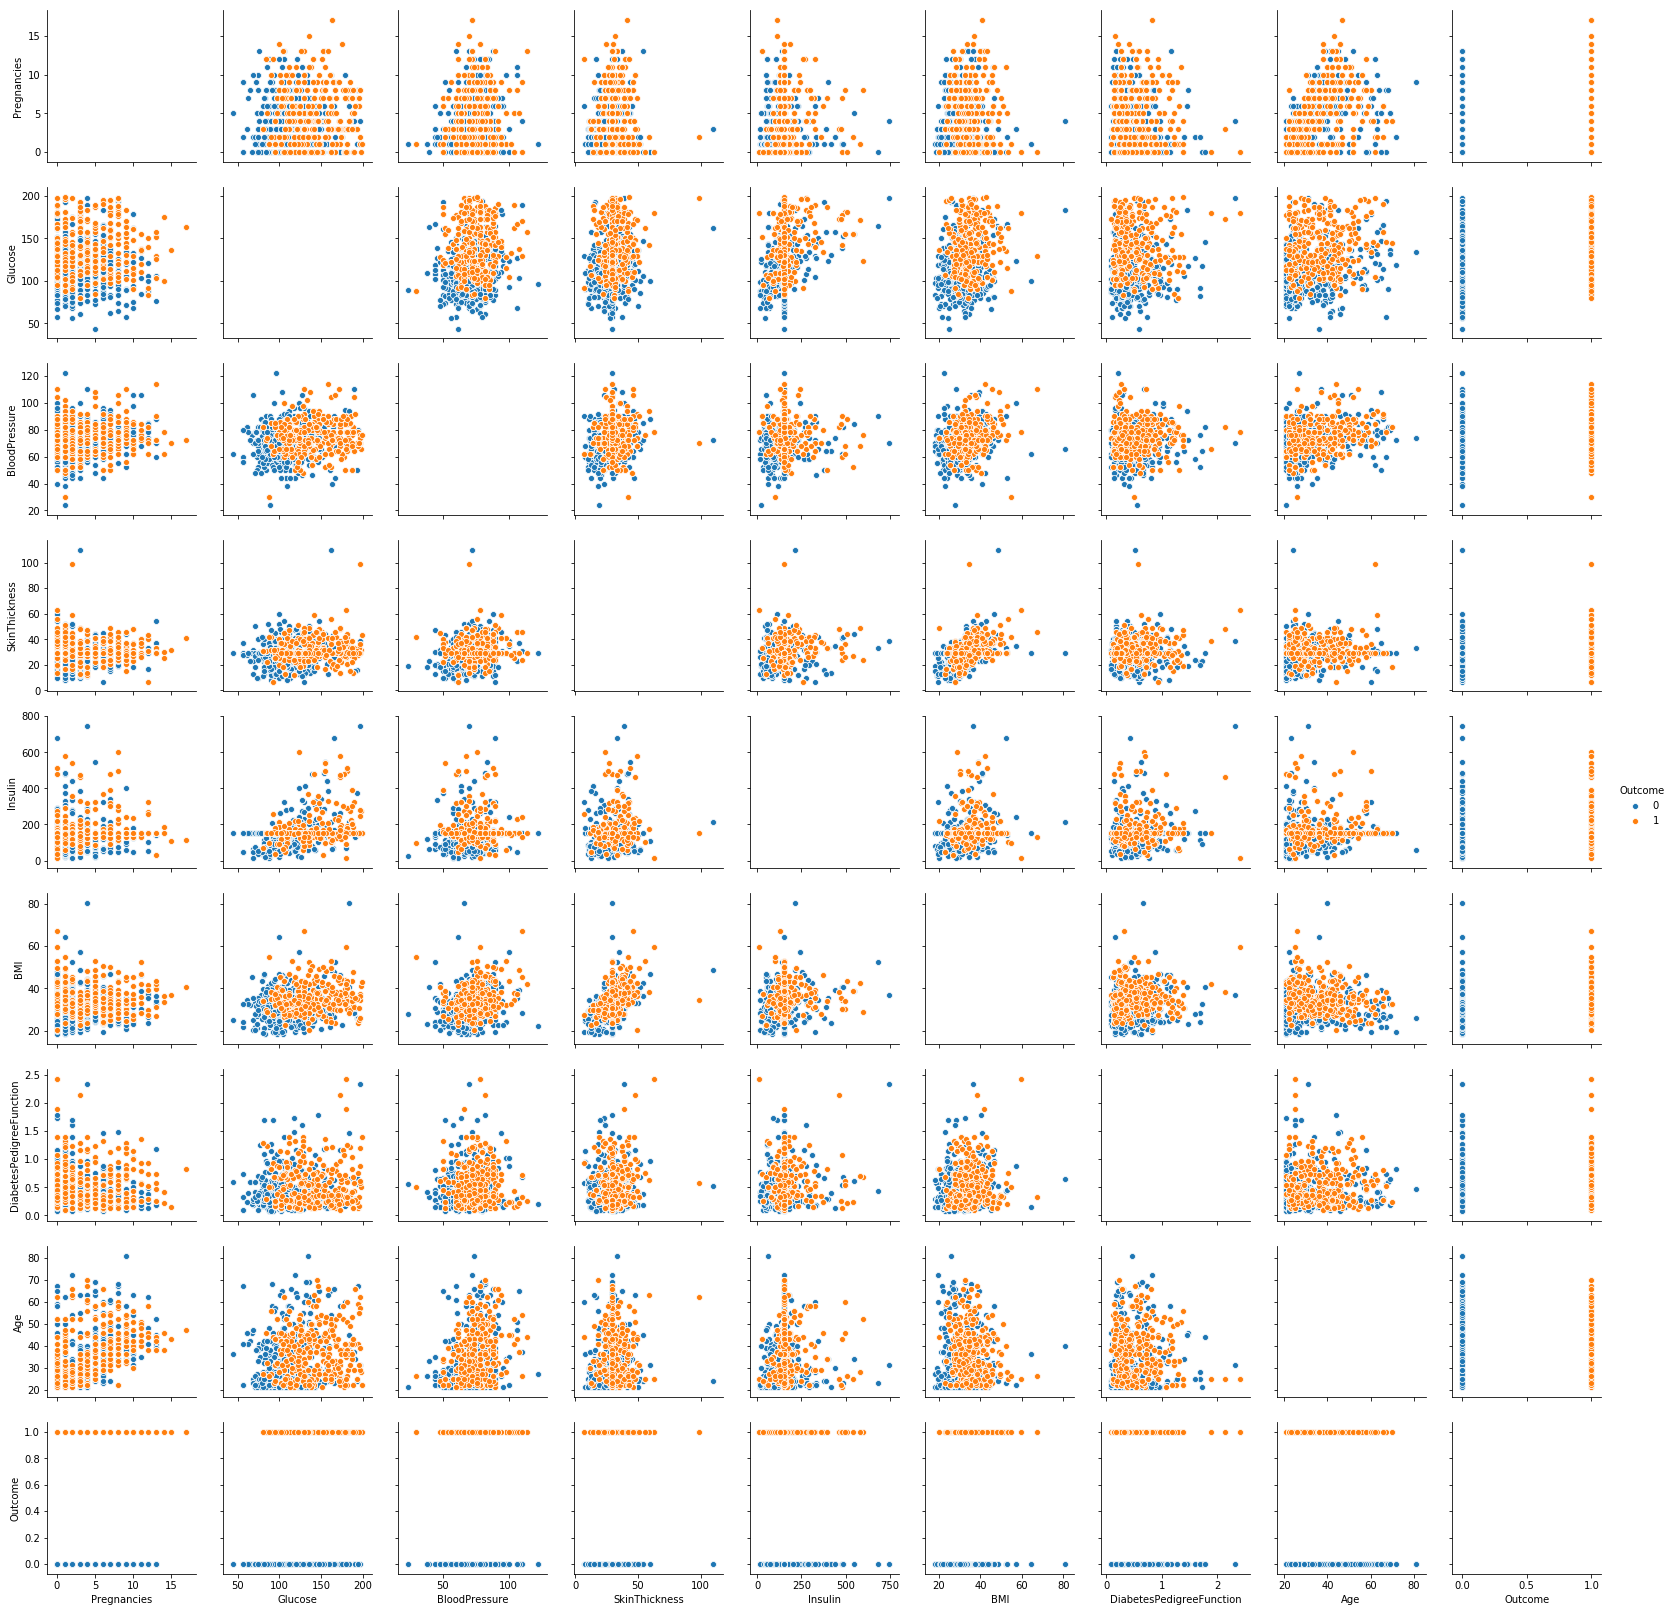

In [11]:
# The pairplot function, to see wether or not specific diagnostic measurements can be seperated 
# into relating to a person being diabetic or not.
sns.pairplot(data=diabetes_data,hue='Outcome',diag_kind='scatter')
plt.show()

By using the sns.pairplot function, we can analyze, wether or not some of the factors can be seggregated into either being potentially more related to the specific outcome class or less. We can see if there is any interrelation between specific factors, and how that interralation corresponds to the person being either diabetic or non-diabetic. This plot shows us the pairwise relation between each attribute, and we can tell, that no single attribute or feature can be clearly seperated by the two outcome classess. So will we be able to diagnostically predict whether or not a person has diabetes, based on the more ore less unseperated diagnostic measurements provided in the data?

In [12]:
# lets see how the factors are correlated to both outcome classess. 
corr_matrix = diabetes_data.corr()
corr_matrix["Outcome"].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.488020
BMI                         0.282182
Age                         0.236509
Pregnancies                 0.224437
Insulin                     0.207696
SkinThickness               0.205527
BloodPressure               0.174481
DiabetesPedigreeFunction    0.155459
Name: Outcome, dtype: float64

The blood glucose level, BMI, age and past pregnancies show to have the predominant correlation that equates to the person as being either diabetic or not.

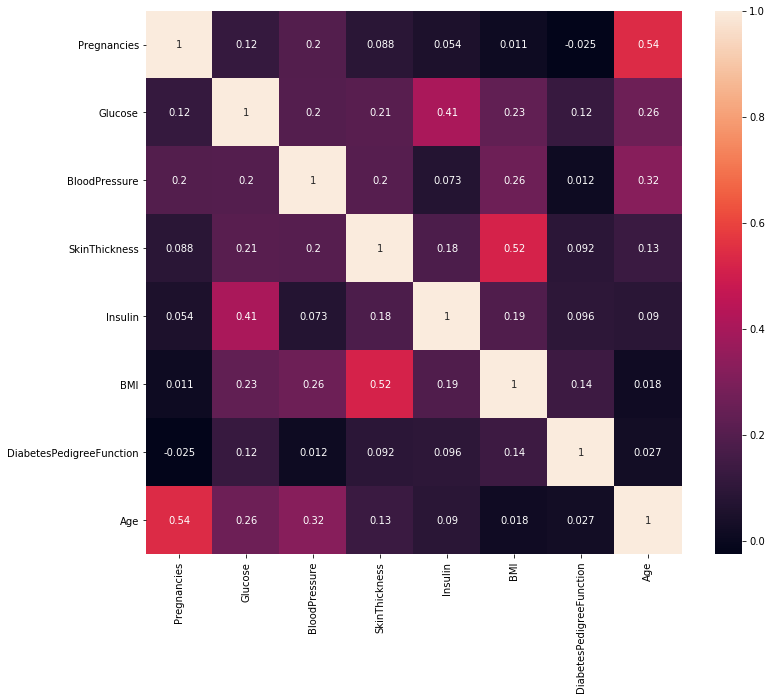

In [13]:
#Inter-correlation between the diagnostic mesurements using a heatmap.
sns.heatmap(diabetes_data[diabetes_data.columns[:8]].corr(),annot=True)
fig=plt.gcf()
fig.set_size_inches(12,10)
plt.show()


On the above provided heatmap, we can see that none of the diagnostic measurements, that will be used to predict wether or not a person is diabetic or not, are strongly correlated. 

# Predictive Machine Learning

To use machine learning algorithms on our dataset, we need to seperate the data into a training set, and a test set. We will train our algorithms on the training set, and validate the accuracy on our testing set. When we seperate the data into the training and testing set to do predictive modeling, the split is completely random. Due to the random split, each set will have completely random assignments of class 1, and class 2 outcomes (diabetic or non-diabetic). Therefore, there might be more class 2 outcomes in the test set, and more class 1 outcomes in the train set. So during predictive modeling, there might be a more accurate prediction for one of the two classess, and a less accurate for the other class. There comes stratification to hand, which ensures that the outcome classes are proportionate in both the training and testing datasets. We will use scikit-learn's highly optimized library for predictive modeling using machine learning.



In [14]:
import sklearn 
from sklearn.model_selection import train_test_split

X = diabetes_data[diabetes_data.columns[:8]]
y = diabetes_data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y) 
# stratify the outcome class


In [15]:
# did it work?
X_train.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
870,4,95.0,64.0,29.341275,153.743295,32.0,0.161,31
1654,6,137.0,61.0,29.341275,153.743295,24.2,0.151,55
1292,2,96.0,68.0,13.000000,49.000000,21.1,0.647,26
1988,4,120.0,68.0,29.341275,153.743295,29.6,0.709,34
1942,6,111.0,64.0,39.000000,153.743295,34.2,0.260,24


In [16]:
# did it work?
y_train.head()

870     1
1654    0
1292    0
1988    0
1942    0
Name: Outcome, dtype: int64

In [17]:
# length is correct?
print(len(y_train), 'train +', len(y_test), 'test')

1400 train + 600 test


Through the following part we will use the highly optimized machine learning algorithms provided by the scikit-learn library to do the predictive modeling.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm #support vector machines
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [36]:
# lets try it with support vector machines using the linear kernel
support_v_m_l = svm.SVC(kernel = 'linear')
support_v_m_l.fit(X_train,y_train)
predict_svm_l = support_v_m_l.predict(X_test)
print("The Accuracy on the training set using the linear kernel is: {:.3f}".format(support_v_m_l.score(X_train,y_train)))
print('The support vector machine =', 'linear', 'kernel is', metrics.accuracy_score(predict_svm_l, y_test), 'accurate in predicting diabetes on the testing set')

The Accuracy on the training set using the linear kernel is: 0.773
The support vector machine = linear kernel is 0.7683333333333333 accurate in predicting diabetes on the testing set


The support vector machine algorithm attempts to seperate the training examples with the largest margin possible, therefore it is also called the "large-margin classifier". Because of it trying to seperate them with the largest margin possible, it is very succeptible to outliers. Therefore the earlier replacement of 0 values was important.

In [49]:
support_v_m_r = svm.SVC(kernel = 'rbf', random_state = 0, C = 0.1)
support_v_m_r.fit(X_train,y_train)
predict_svm_r = support_v_m_r.predict(X_test)
print("The Accuracy on the training set using the rbf kernel is: {:.3f}".format(support_v_m_r.score(X_train,y_train)))
print('The support vector machine =', 'radial', 'kernel is', metrics.accuracy_score(predict_svm_r, y_test), 'accurate in predicting diabetes on the testing set')
    

The Accuracy on the training set using the rbf kernel is: 0.658
The support vector machine = radial kernel is 0.6583333333333333 accurate in predicting diabetes on the testing set


The radial "rbf" or "gaussian" kernel is a non-linear kernel, that finds the similarity between a point, also called landmarks and the input variables, to make a new feature. They create a landmark for every training example, and then looks at how close a new set of examples (testing set) is to the original training set. Because we have a lot of replaced values that are present in the training as well as in the test set, the score of accuracy is very high, as the similarity between the landmarks (training examples) and the new set of examples (test examples) is 100%. Therefore we implemented the variable "random_state" which gives the data set a further shuffle, reducing the probability of two points being exemplified in both the training and testing set, and set the regulaization parameter "C", to 0.1, to encourgage a larger margin, therefore a more simple decision making function. This reduces the possibility of the algorithm to overfit on the training set, at the cost of training accuracy. 

In [56]:
# logistic regression algorithm: definition below: 
logistic_r_m = LogisticRegression(C = 0.1)
logistic_r_m.fit(X_train,y_train)
predict_lr = logistic_r_m.predict(X_test)
print("The Accuracy on the training set using the logistic Regression is: {:.3f}".format(logistic_r_m.score(X_train,y_train)))
print("the logistic regression algorrithm accuracy to predict diabetes on the testing set is", metrics.accuracy_score(predict_lr,y_test))

The Accuracy on the training set using the logistic Regression is: 0.751
the logistic regression algorrithm accuracy to predict diabetes on the testing set is 0.7333333333333333


The logistic regression algorithms objective is to predict a target variable (y) to be either 1 or 0, 0 being the negative class -absence of diabetes, and 1 being the positive class - presence of diabetes. It is used to describe data by making use of one or more predictive variables, to explain its relationship to a single dependent variable. We also implement some regularization to prevent overfitting.  

In [51]:
# decision tree algorithm 
decision_t_m = DecisionTreeClassifier(random_state = 1, max_depth = 2)
decision_t_m.fit(X_train, y_train)
predict_dt = decision_t_m.predict(X_test)
print("The Accuracy on the training set using the decision tree classifier is: {:.3f}".format(decision_t_m.score(X_train,y_train)))
print("the decision tree model is able to predict diabetes with", metrics.accuracy_score(predict_dt,y_test), "accuracy on the testing set")


The Accuracy on the training set using the decision tree classifier is: 0.760
the decision tree model is able to predict diabetes with 0.7616666666666667 accuracy on the testing set


The decision tree classifier mimics the human decision making process. It uses observations about a specific incident, to come to conclusions about the target value. It is a great multivariate algorithm for predictive modeling, as it can incorporate multiple independent variables to conclude on a dependent variable. The decision tree model learns, by splitting the inputs into subsets of information based on attribute value. Because of the decision tree model choosing attributes itself, the randomness of attributes needs to be set. Also, we want to minimize the probability of the algorithm to overfit, thus, we set the max_depth variable to 2. This minimizes the possibility of the algorithm to overfit on our training set to get a more accurate probability output.


In [58]:
A = []
classifications = ['Linear Support Vector Machine', 'Radial Support Vector Machine', 'Logistic Regression', 'Decision Tree Model']
algorithms = [svm.SVC(kernel = 'linear'), svm.SVC(kernel = 'rbf', random_state = 0, C = 0.1), LogisticRegression(C=0.1), DecisionTreeClassifier(random_state = 0, max_depth = 2)]
for i in algorithms:
    algorithm = i 
    algorithm.fit(X_train, y_train)
    algorithm_prediction = algorithm.predict(X_test)
    A.append(metrics.accuracy_score(algorithm_prediction, y_test))
algorithms_dataframe = pd.DataFrame(A, index = classifications)
algorithms_dataframe.columns = ['Accuracy']
algorithms_dataframe


,Accuracy
Linear Support Vector Machine,0.768333
Radial Support Vector Machine,0.658333
Logistic Regression,0.733333
Decision Tree Model,0.761667


# Conclusion

We can conclude that the Support Vector machine with the linear kernel and the linear regression algorithm provide us with the highest probability. Even though the feature inputs (diagnostic measurements) were not strongly correlated to the prevelance of a person having diabetes or not, highly optimized algorithms can still find patterns. This is due to their nature of being able to implement multiple variables and their correlation to the outcome, to find conclusions about the target variable. This is extremely important in future research, as data-scientists can possibly be more accurate about individuals having specific diseases, through the usage of machine and deep learning, than a human could. It could incrementaly reduce treatment costs, and specifically reduce costs of symptom analysis. Machine learning algorithms for classification such as logistic regression, support vector machines and the decision tree classifier, can be used to predict based on inputs very successfully. Even if the symptom dataframe from a person is limited, through the usage of a large database and their correlations to a specific outcome, a person can be diagnosed with minimal inputs. Throughout this kernel, we have analysed certain diagnostic measurements, their inter-relation, and correlation to the outcome of a person with or without diabetes. Further on, we have implemented machine learning algorithms, to test wether or not, a diagnosis can be made successfully with the availabe data. Diabetes is a serious epidemic, and according to the american diabetes association, it is the 7th leading cause for deaths in the united states alone, with approximately 80,000 deaths caused by it in only 2015. It is important to further on expand research on it, to come up with more sophisticated solutions, in which process machine learning and deep learning can aid. 